# Using Scanpy with BD Rhapsody multi-omic single-cell data

This is an introduction on how to install and use the __[Scanpy](https://scanpy.readthedocs.io/en/stable/index.html)__ package to analyze single-cell data produced by the BD Rhapsody Sequence Analysis Pipeline. It follows __[Scanpy's Preprocessing and clutering 3k PBMCs tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)__, which in turn follows __[Seurat's guided clustering tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html)__. 

Rhapsody demo data used for this tutorial can be found here.

> About the demo data:
> This experiment used previously frozen resting human PBMCs and enriched human B cells that were multiplexed and 
> stained with Immune Discovery Panel + 4 AbSeq drop-ins and a 15-plex Abseq panel, respectively, whereby ~10,000 
> cells were captured with the BD Rhapsody Single Cell System and processed using the BD Rhapsody TCR/BCR Full Length, 
> mRNA Whole Transcriptome Analysis (WTA), BD AbSeq, and Sample Tag Library Preparation protocol.

The package leidenalg can be installed with:
> conda install -c conda-forge leidenalg



In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [3]:
results_file = 'rhapsody_scanpy_demo.h5ad'  # the file that will store the analysis results

Rather than use a mtx file, we import the Rhapsody [project_name]_RSEC_MolsPerCell.csv output file. This file contains molecular counts for both mRNA and/or AbSeq expression.

In [4]:
df_counts = pd.read_table('Combined_RhapTCRBCRdemo_RSEC_MolsPerCell.csv', sep=',', skiprows=7, index_col=0)
df_counts.head()

CCR7|CCR7|AHS0273|pAbO  CD11b:M1_70|ITGAM|AHS0005|pAbO  \
Cell_Index                                                           
490968                          49                               3   
541737                          33                               5   
747419                          29                              16   
419100                          47                               3   
589233                          17                               5   

            CD11c:B-LY6|ITGAX|AHS0056|pAbO  CD127|IL7R|AHS0028|pAbO  \
Cell_Index                                                            
490968                                   8                        1   
541737                                  39                        6   
747419                                  31                       18   
419100                                  24                        5   
589233                                2505                        2   

            CD134:ACT35|TNFRSF4|AHS0013|pAbO  CD137|TNFRSF9|AHS0003|pAbO  \
Cell_Index                                                                 
490968                                    76                          14   
541737                                    30                          63   
747419                                    25                          61   
419100                                    20                          48   
589233                                    11                           7   

            CD14:MPHIP9|CD14|AHS0037|pAbO  CD161:HP-3G10|KLRB1|AHS0205|pAbO  \
Cell_Index                                                                    
490968                                 10                                 8   
541737                                 15                                17   
747419                                 36                                 8   
419100                                 17                                11   
589233                                 15                                 9   

            CD16:3G8|FCGR3A|AHS0053|pAbO  CD183|CXCR3|AHS0031|pAbO  ...  ZW10  \
Cell_Index                                                          ...         
490968                                14                        84  ...     3   
541737                                50                       139  ...     0   
747419                                31                        36  ...     0   
419100                                76                        66  ...     1   
589233                                11                        20  ...     0   

            ZWILCH  ZWINT  ZXDA  ZXDB  ZXDC  ZYG11A  ZYG11B  ZYX  ZZEF1  
Cell_Index                                                               
490968           2      6     0     0     1       0       1    1      1  
541737           1      2     0     1     0       0       0    0      0  
747419           0     12     0     0     0       0       0    0      1  
419100           2      6     0     0     0       0       0    0      0  
589233           0      0     0     0     1       0       0    7      0  

[5 rows x 25328 columns]

In [5]:
adata = ad.AnnData(df_counts)
adata

/Users/miasteinberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 7338 × 25328

And now we pick back up at the Preprocessing step of the Scanpy tutorial.

normalizing counts per cell
    finished (0:00:01)


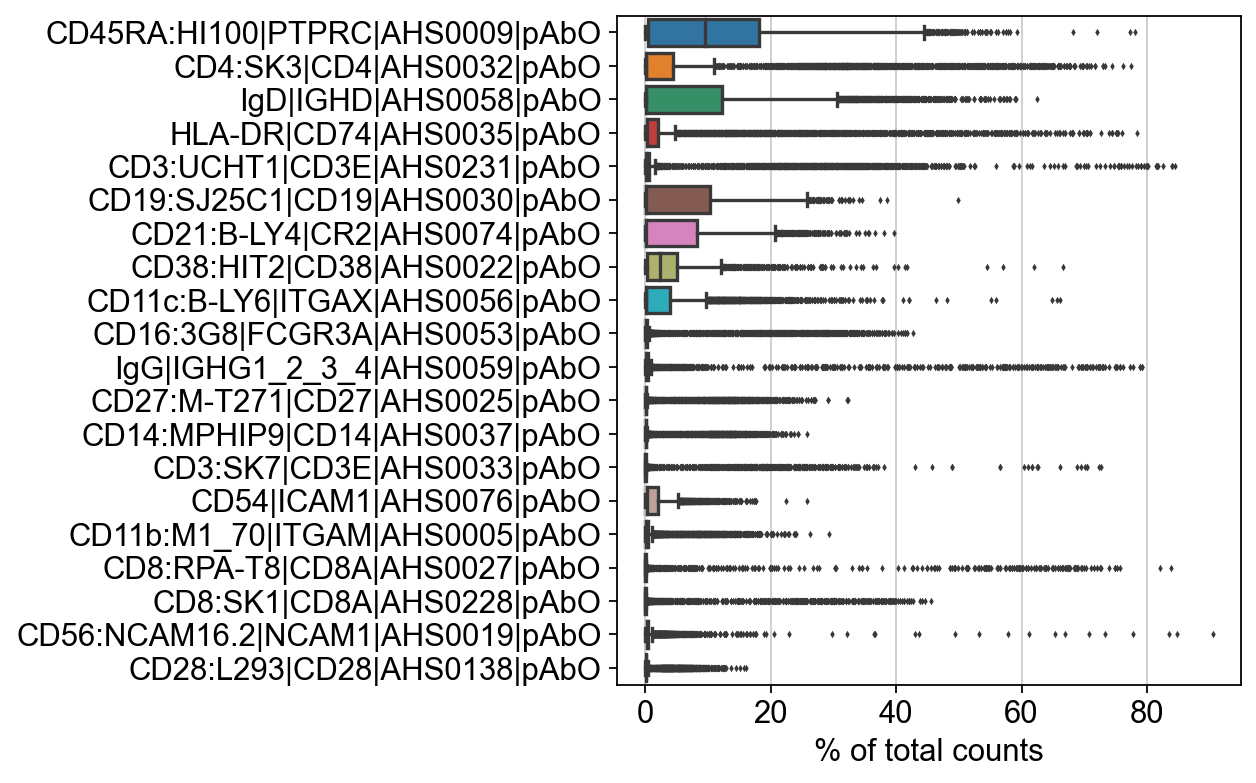

In [6]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
# If you have AbSeqs, they will usually be the most abundant biofeature.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [7]:
# Basic filtering:

# Filter out cells with < min_genes
sc.pp.filter_cells(adata, min_genes=200)

# Filter out genes detected in < min_cells
sc.pp.filter_genes(adata, min_cells=3)

filtered out 6 cells that have less than 200 genes expressed
filtered out 6388 genes that are detected in less than 3 cells


In [8]:
# With Rhapsody data, high mitochondrial read % does not always indicate poor cell quality or dying cells

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in mitochondrial genes

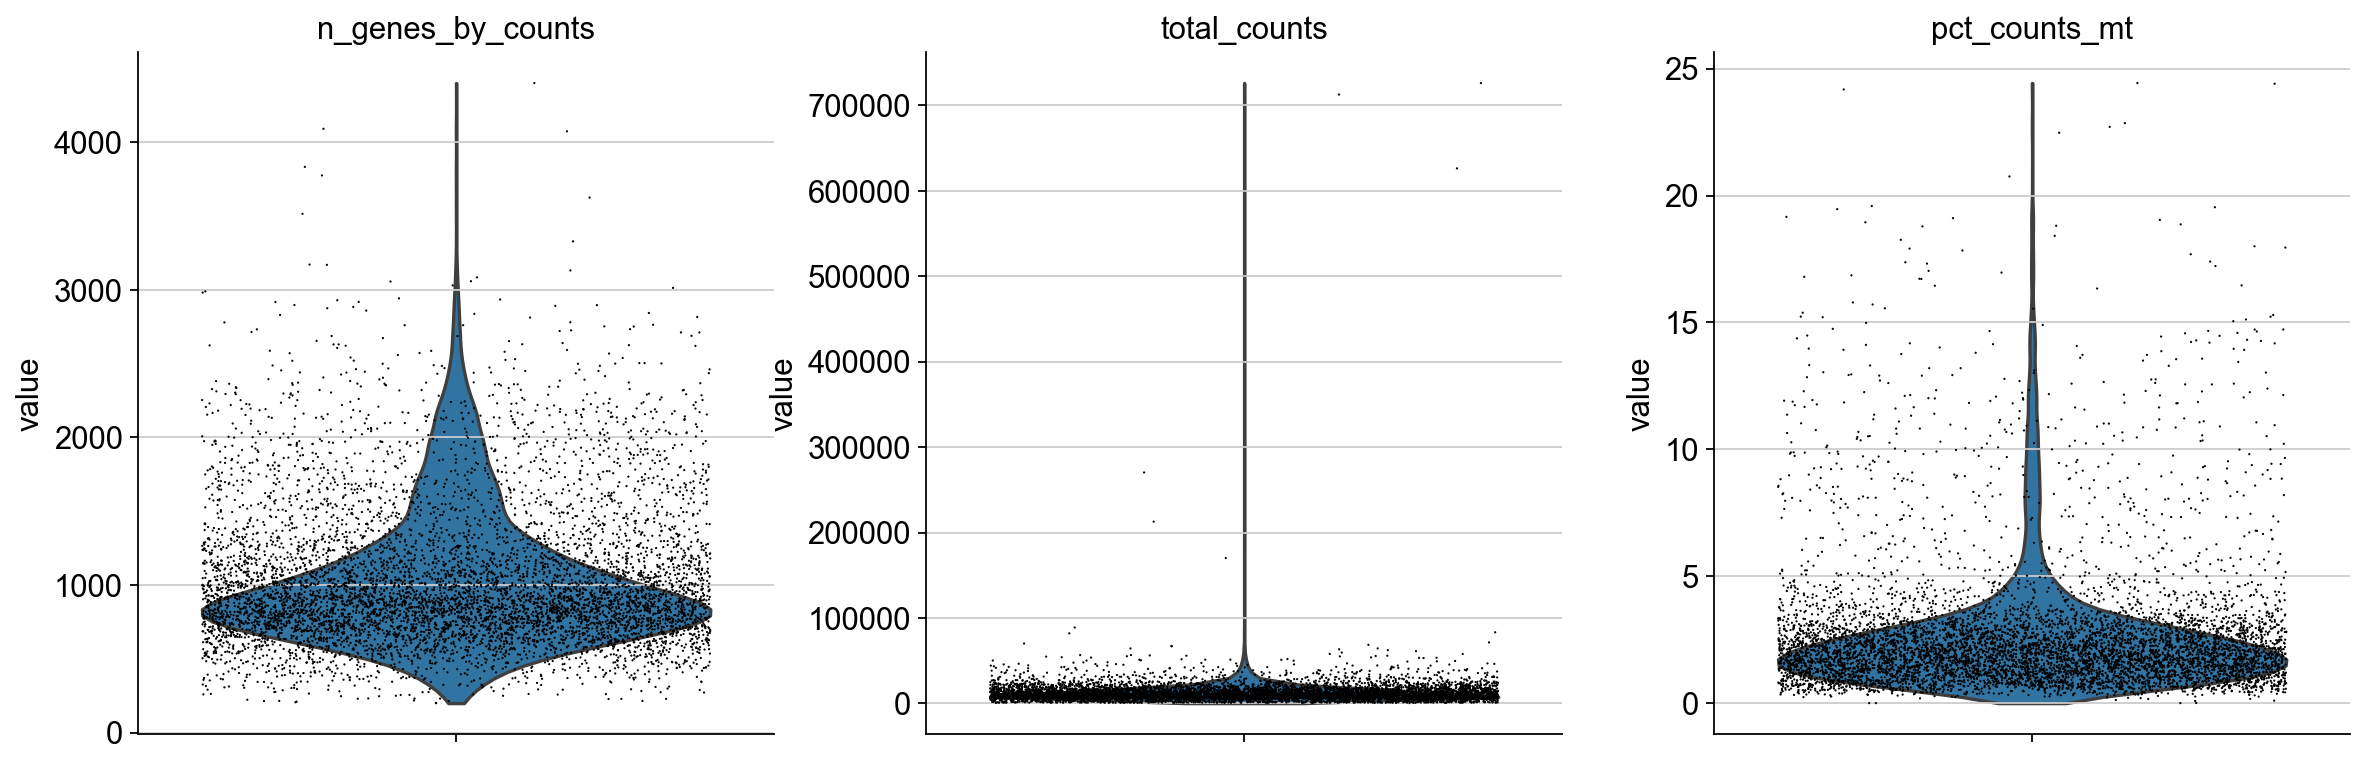

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

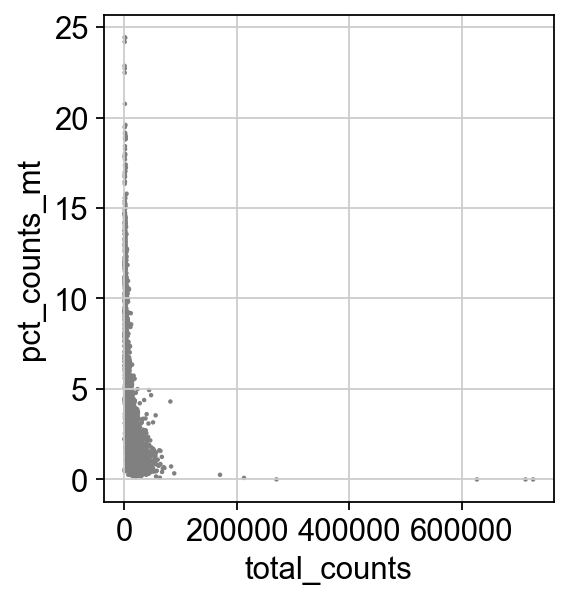

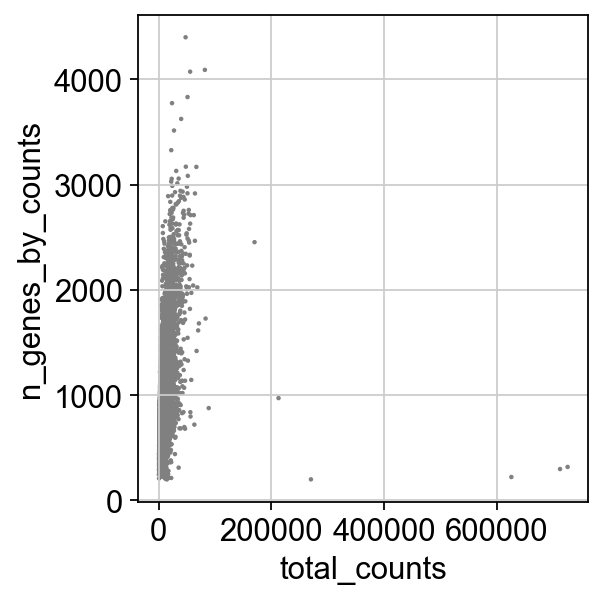

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Remove cells that have too many mitochondrial genes expressed or too many total counts.

Actually do the filtering by slicing the AnnData object.

In [11]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)

/Users/miasteinberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [13]:
sc.pp.log1p(adata)

Identify highly-variable genes.

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


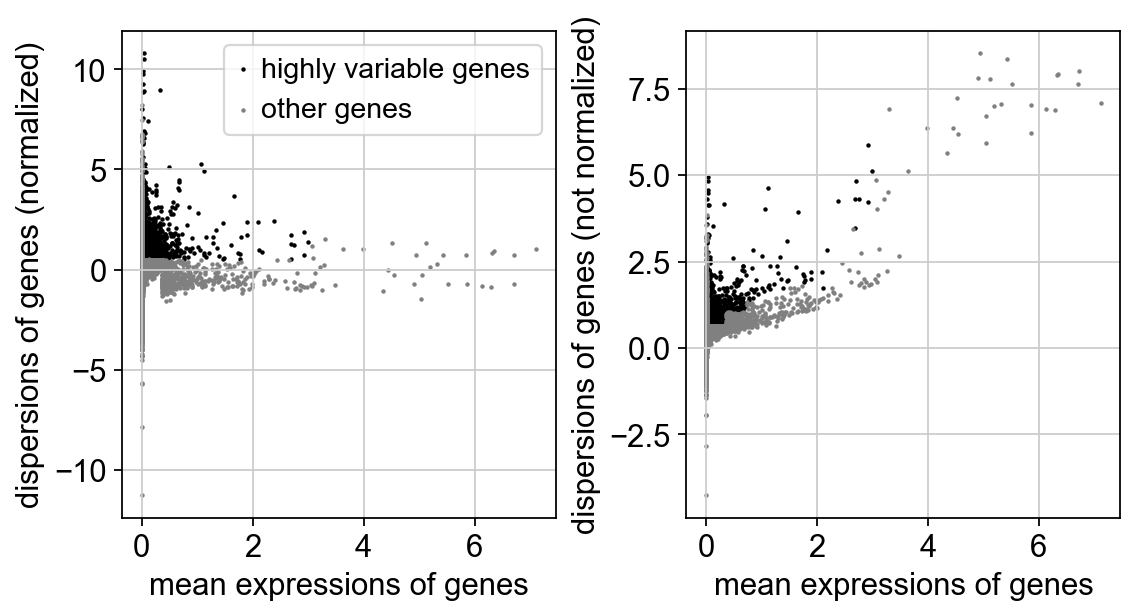

In [15]:
sc.pl.highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

NOTE - You can get back an AnnData of the object in .raw by calling .raw.to_adata().

In [16]:
adata.raw = adata

Actually do the filtering

In [17]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [18]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:20)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [19]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [20]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

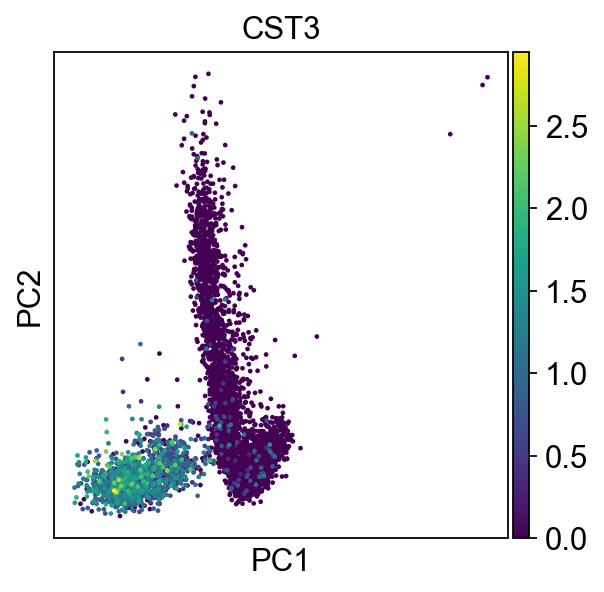

In [21]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.

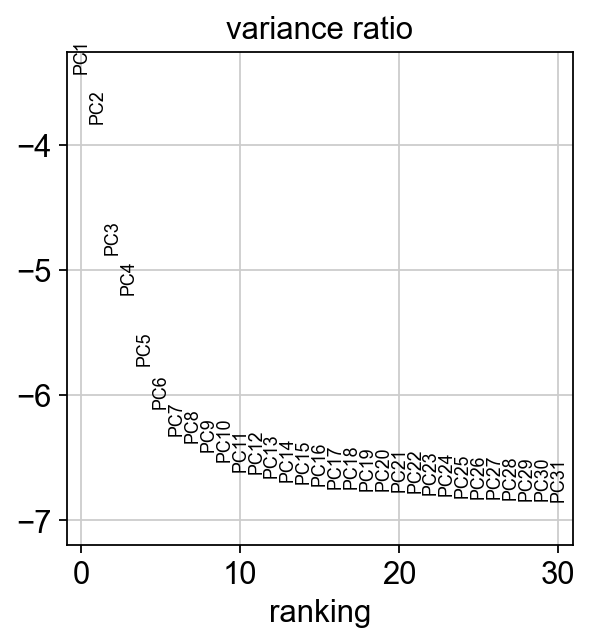

In [22]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [23]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 6640 × 2970
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [25]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


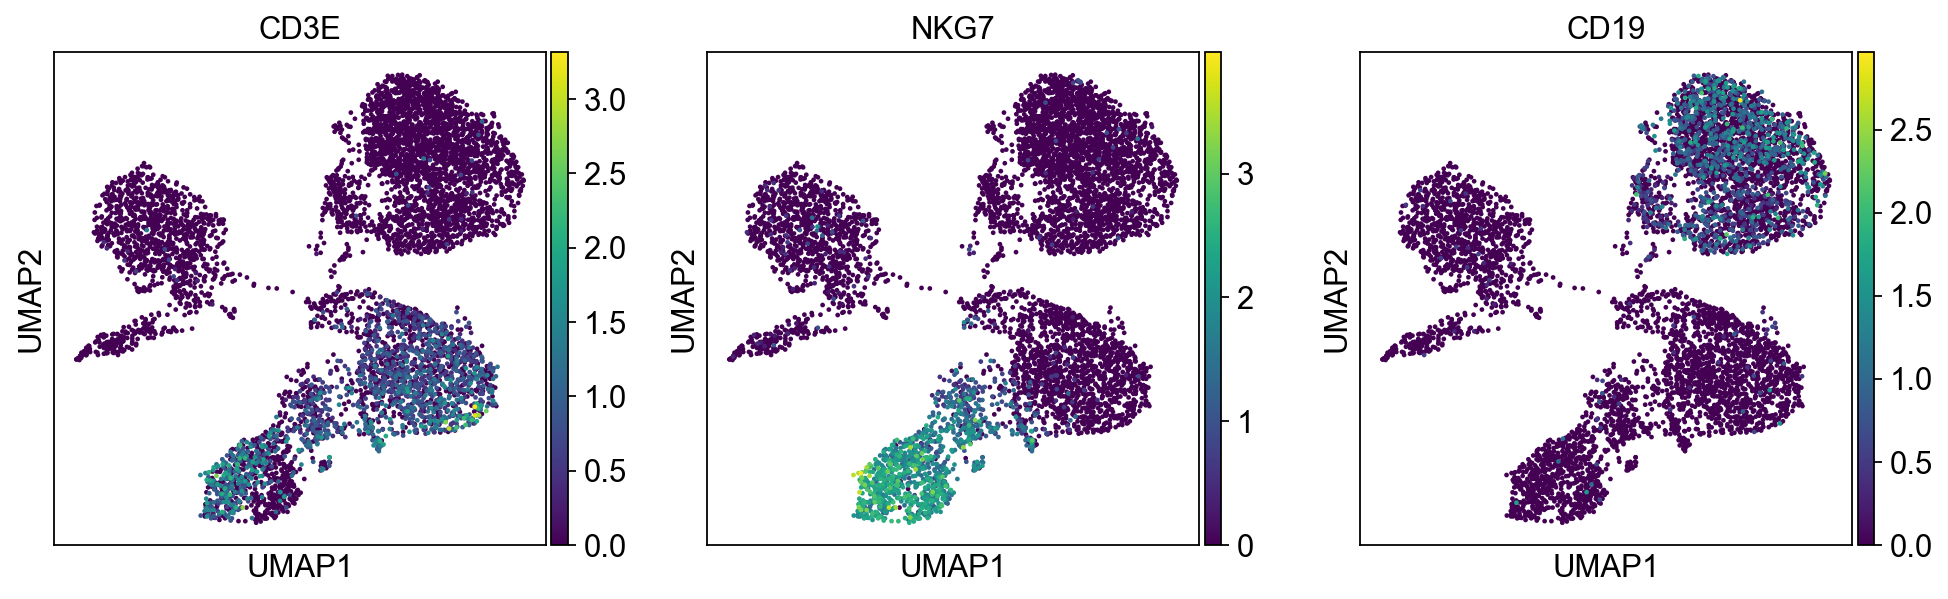

In [26]:
sc.pl.umap(adata, color=['CD3E', 'NKG7', 'CD19'])

As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.

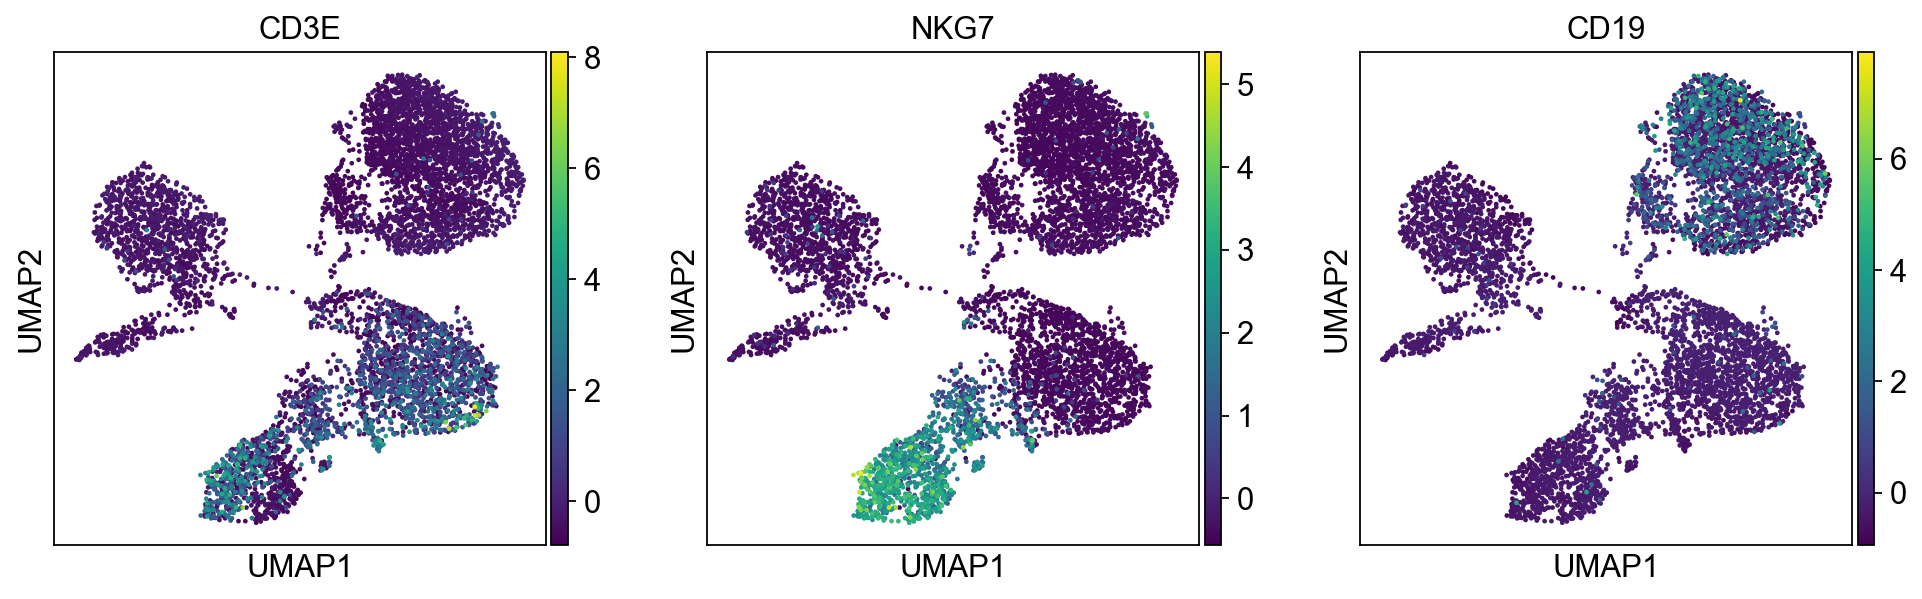

In [27]:
sc.pl.umap(adata, color=['CD3E', 'NKG7', 'CD19'], use_raw=False)

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [28]:
sc.tl.leiden(adata, resolution=0.5)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

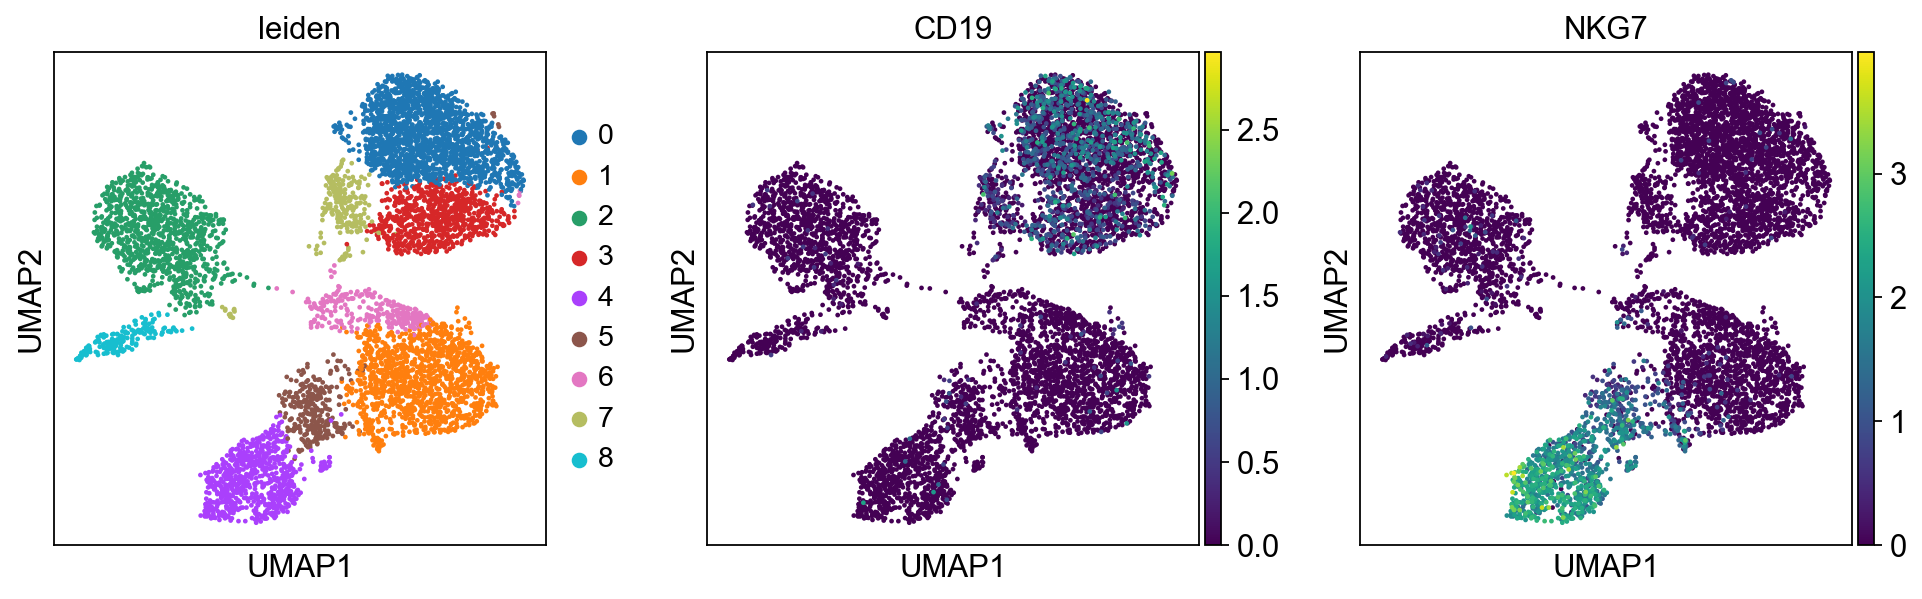

In [29]:
sc.pl.umap(adata, color=['leiden', 'CD19', 'NKG7'])

Save the result.

In [30]:
adata.write(results_file)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


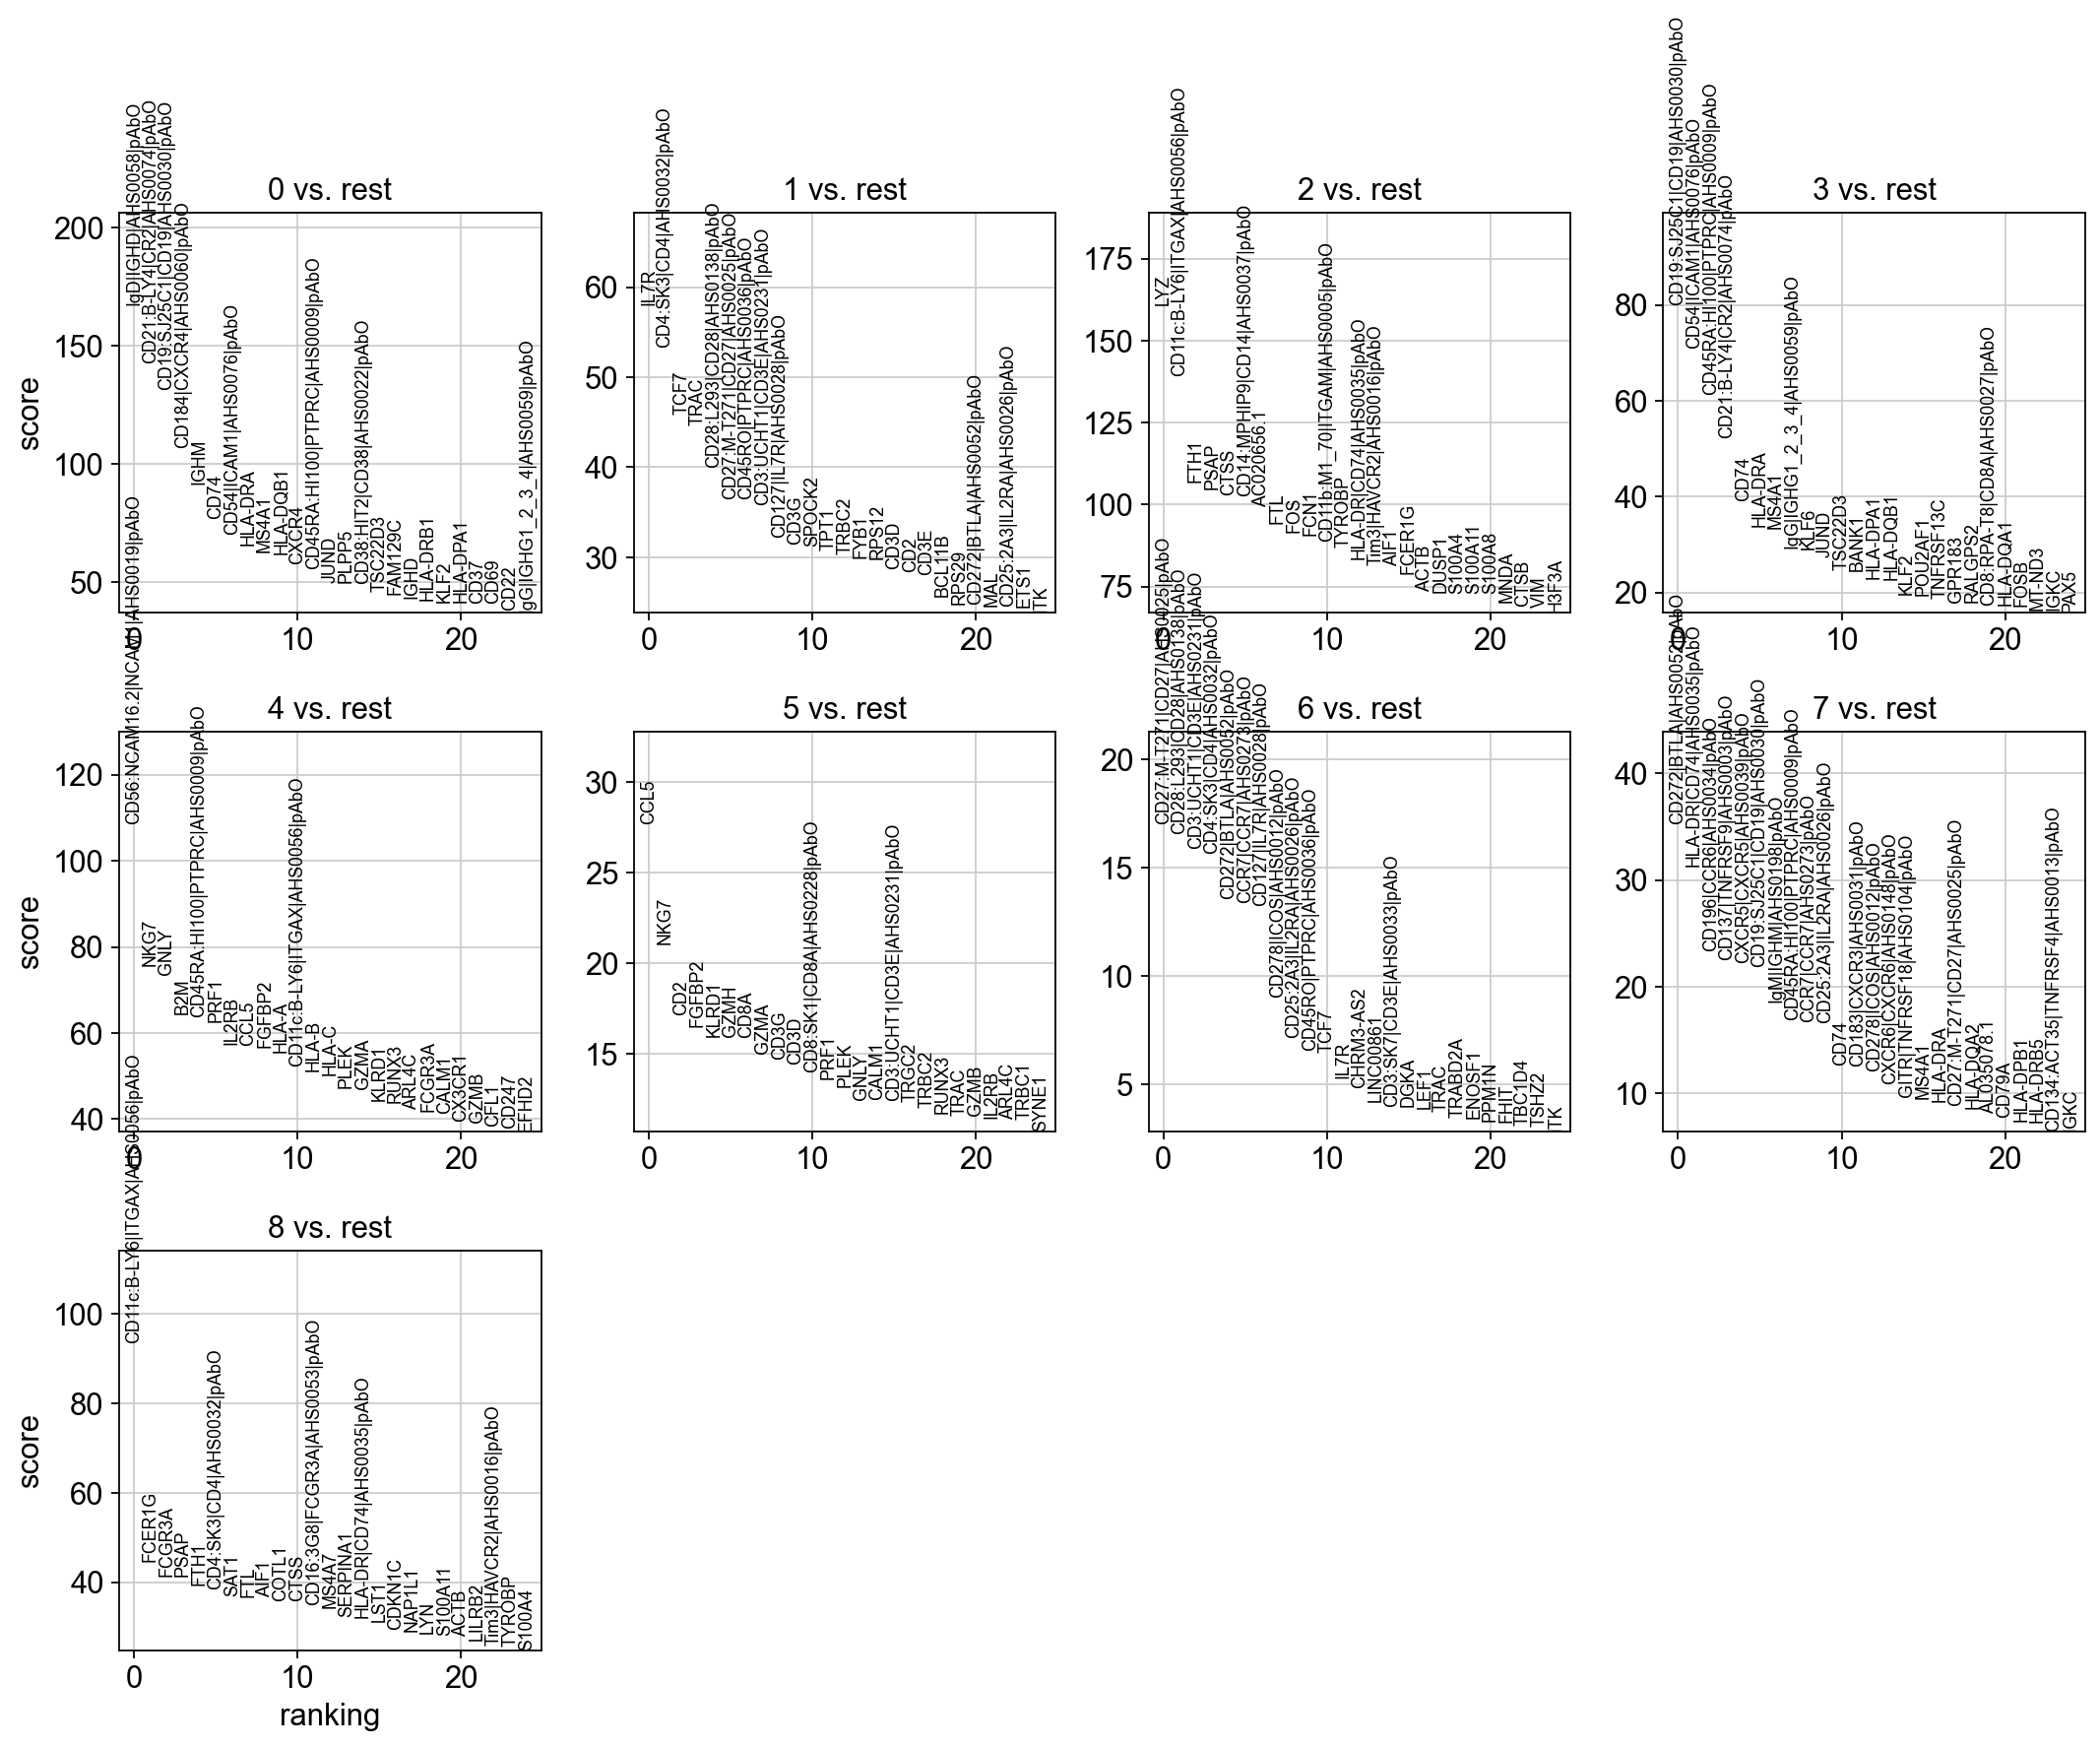

In [31]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [32]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. We recommend using the latter in publications, see e.g., Sonison & Robinson (2018). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:17)


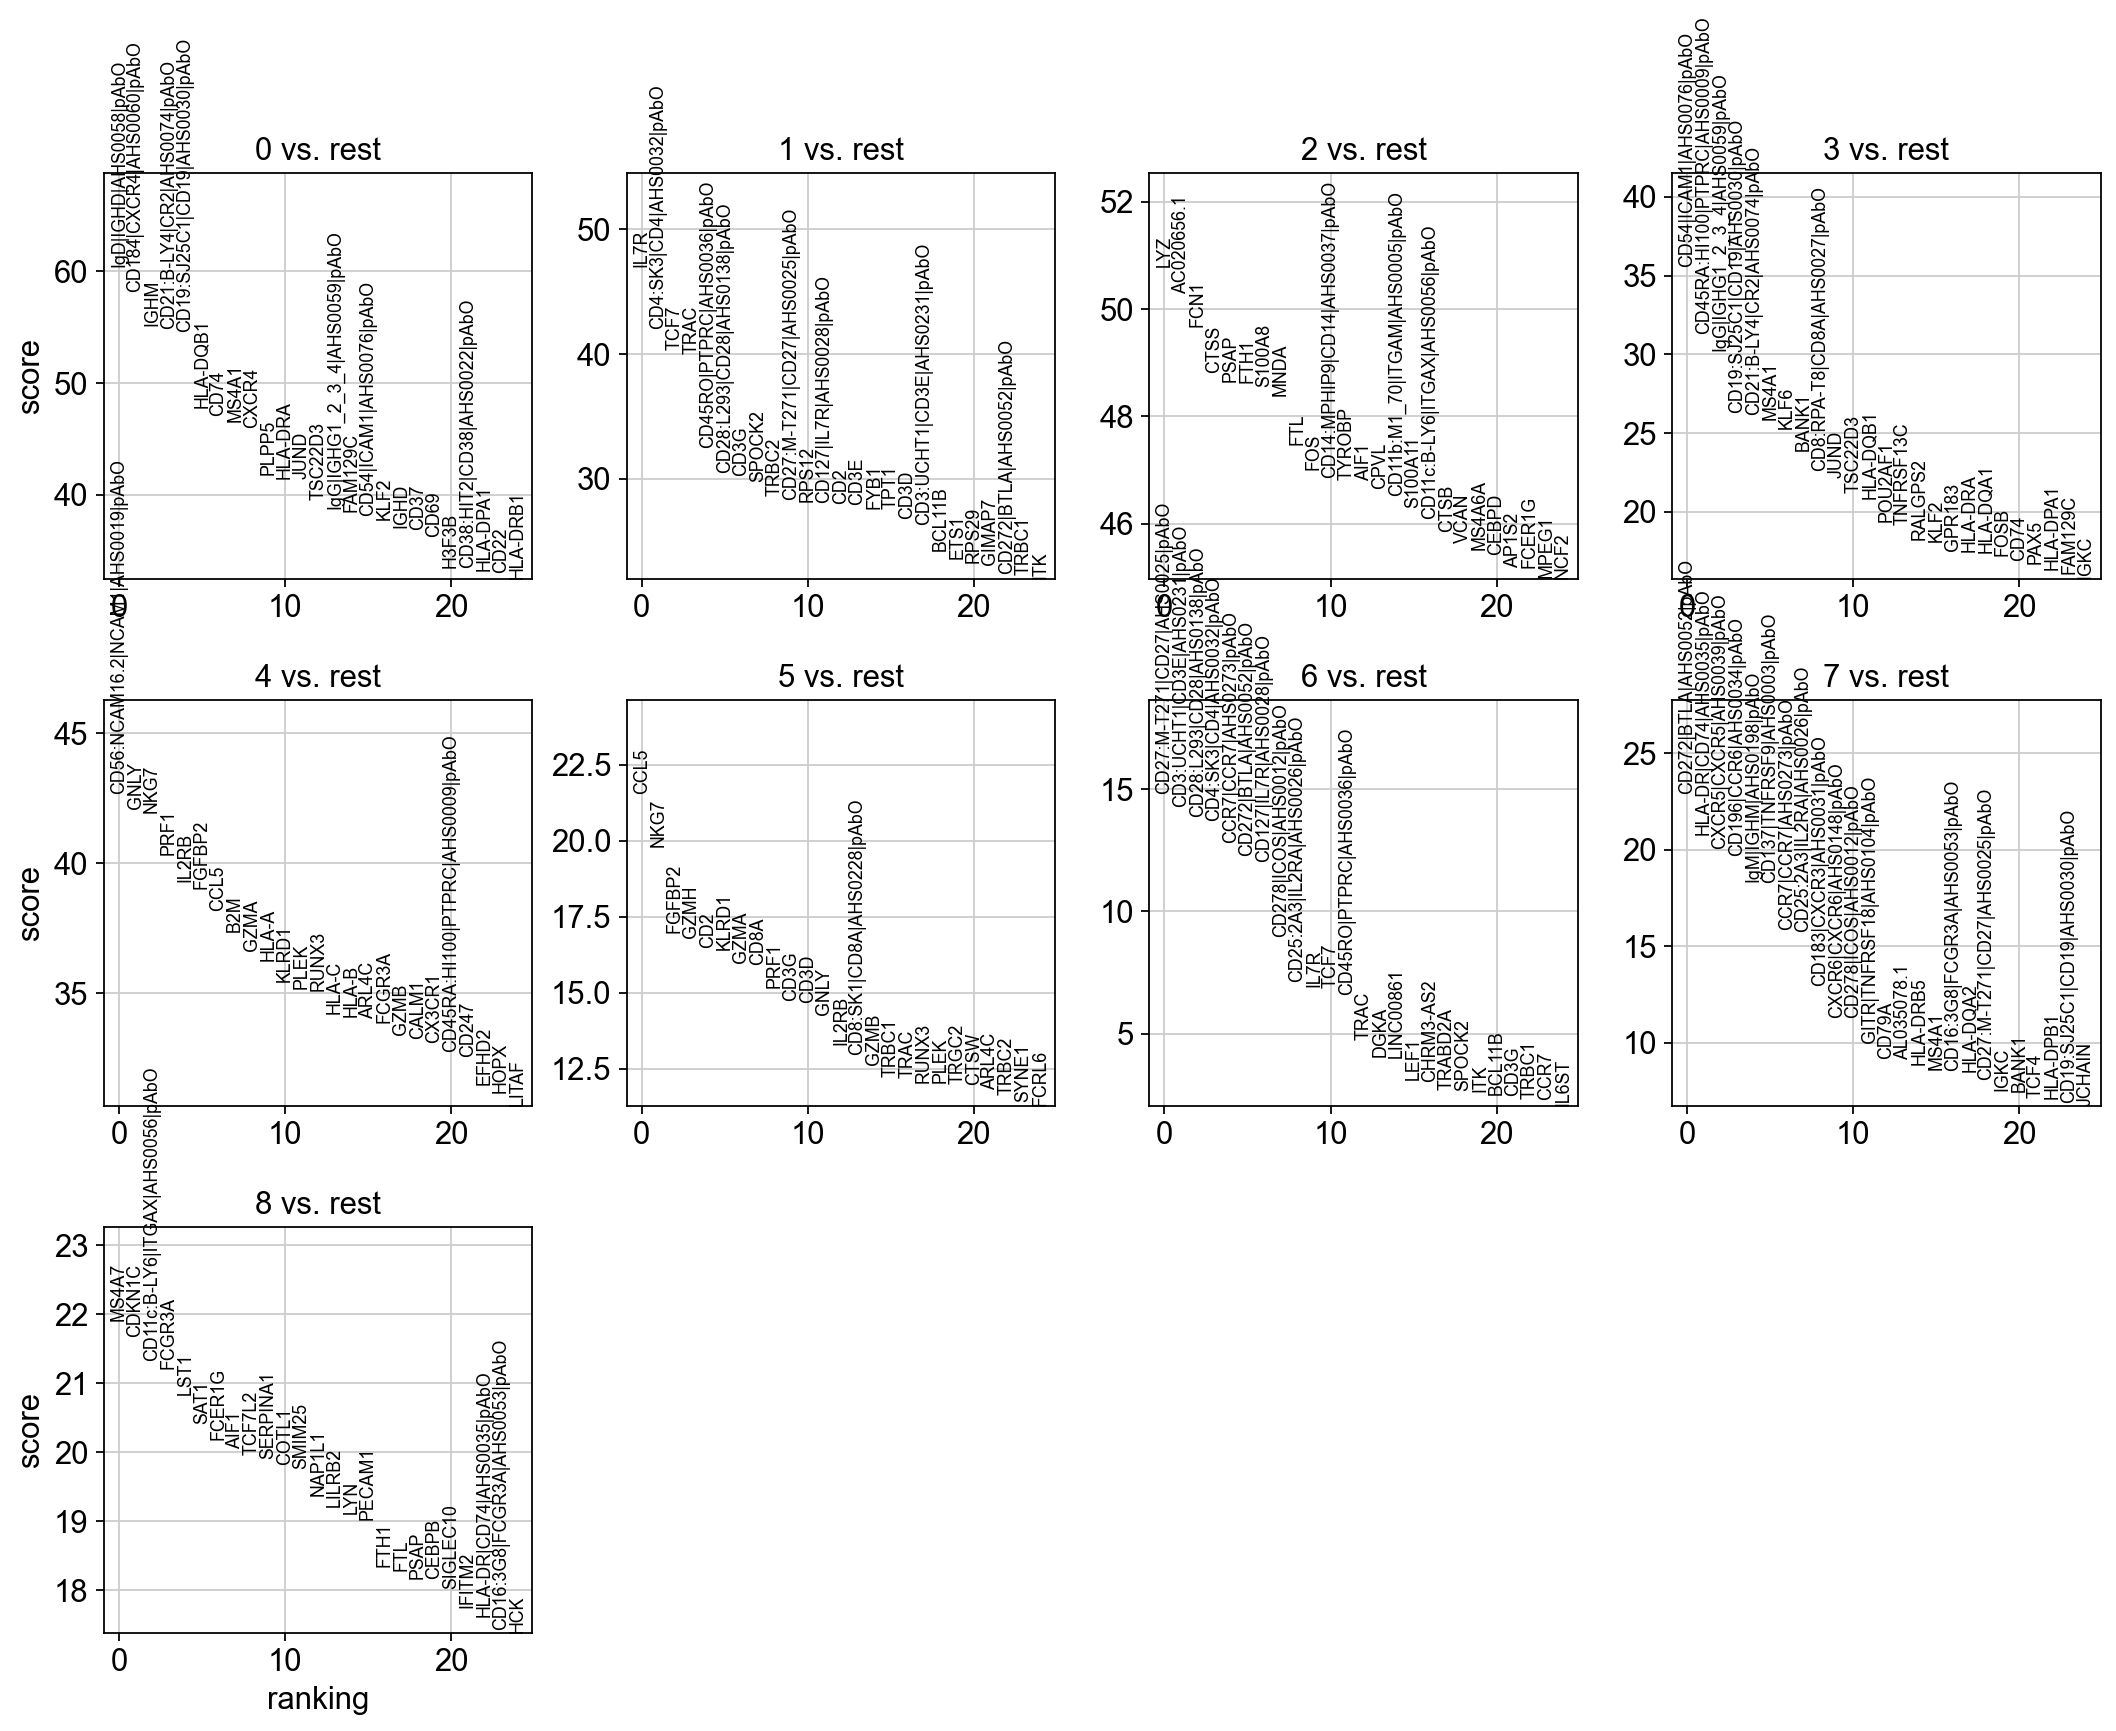

In [33]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [34]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

ranking genes
    finished (0:00:34)


/Users/miasteinberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


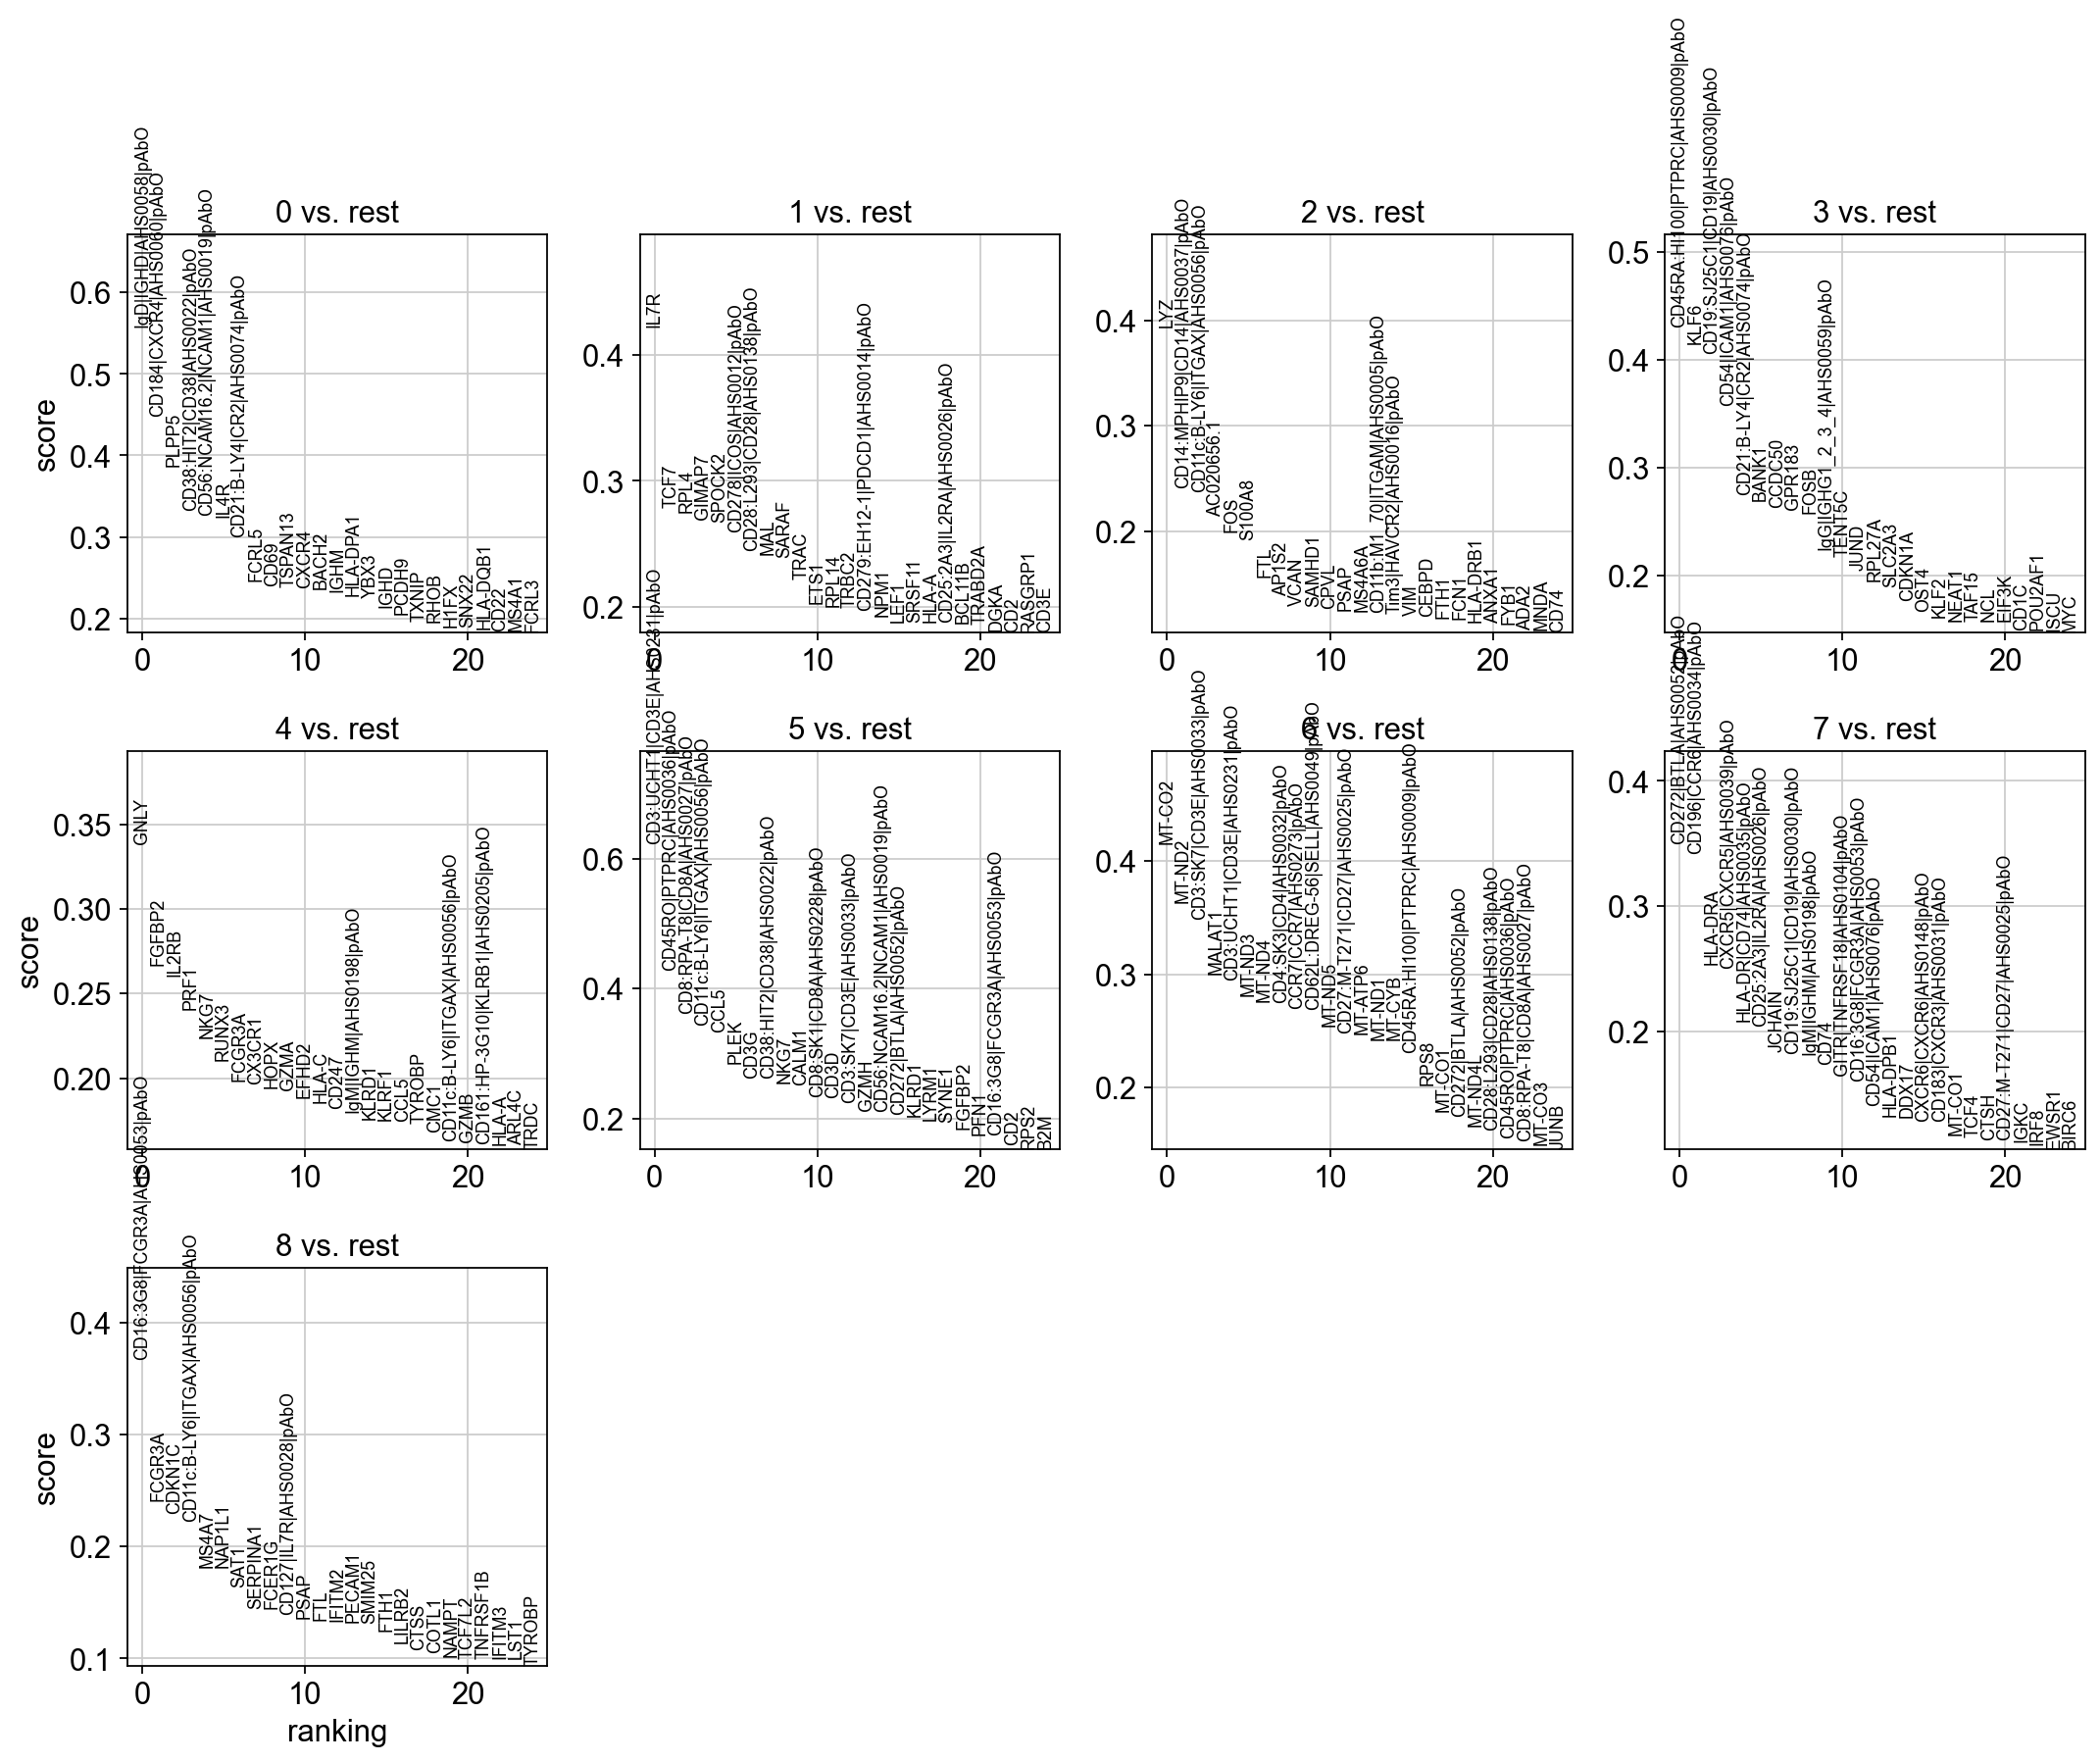

In [35]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Let us also define a list of marker genes for later reference.

In [36]:
marker_genes = ['IL7R', 'FOS', 'KLF6', 'FGFBP2', 'PLPP5', 'LGALS3', 'IGHM', 'TRBC2', 'LYZ', 'CD8A', 'GZMK', 
                'HLA-DRA', 'CDKN1C', 'BTN3A1', 'TCL1A', 'FCER1A', 'XCL2', 'JCHAIN']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [37]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, …, 7 in a dataframe.

In [38]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0                          1           2  \
0          IgD|IGHD|AHS0058|pAbO                       IL7R         LYZ   
1       CD184|CXCR4|AHS0060|pAbO   CD4:SK3|CD4|AHS0032|pAbO  AC020656.1   
2                           IGHM                       TCF7        FCN1   
3    CD21:B-LY4|CR2|AHS0074|pAbO                       TRAC        CTSS   
4  CD19:SJ25C1|CD19|AHS0030|pAbO  CD45RO|PTPRC|AHS0036|pAbO        PSAP   

                                 3                                 4       5  \
0          CD54|ICAM1|AHS0076|pAbO  CD56:NCAM16.2|NCAM1|AHS0019|pAbO    CCL5   
1  CD45RA:HI100|PTPRC|AHS0009|pAbO                              GNLY    NKG7   
2     IgG|IGHG1_2_3_4|AHS0059|pAbO                              NKG7  FGFBP2   
3    CD19:SJ25C1|CD19|AHS0030|pAbO                              PRF1    GZMH   
4      CD21:B-LY4|CR2|AHS0074|pAbO                             IL2RB     CD2   

                               6                         7  \
0  CD27:M-T271|CD27|AHS0025|pAbO   CD272|BTLA|AHS0052|pAbO   
1    CD3:UCHT1|CD3E|AHS0231|pAbO  HLA-DR|CD74|AHS0035|pAbO   
2    CD28:L293|CD28|AHS0138|pAbO  CXCR5|CXCR5|AHS0039|pAbO   
3       CD4:SK3|CD4|AHS0032|pAbO   CD196|CCR6|AHS0034|pAbO   
4         CCR7|CCR7|AHS0273|pAbO     IgM|IGHM|AHS0198|pAbO   

                                8  
0                           MS4A7  
1                          CDKN1C  
2  CD11c:B-LY6|ITGAX|AHS0056|pAbO  
3                          FCGR3A  
4                            LST1

Get a table with the scores and groups.

In [39]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n  0_p                        1_n  \
0          IgD|IGHD|AHS0058|pAbO  0.0                       IL7R   
1       CD184|CXCR4|AHS0060|pAbO  0.0   CD4:SK3|CD4|AHS0032|pAbO   
2                           IGHM  0.0                       TCF7   
3    CD21:B-LY4|CR2|AHS0074|pAbO  0.0                       TRAC   
4  CD19:SJ25C1|CD19|AHS0030|pAbO  0.0  CD45RO|PTPRC|AHS0036|pAbO   

             1_p         2_n  2_p                              3_n  \
0   0.000000e+00         LYZ  0.0          CD54|ICAM1|AHS0076|pAbO   
1   0.000000e+00  AC020656.1  0.0  CD45RA:HI100|PTPRC|AHS0009|pAbO   
2   0.000000e+00        FCN1  0.0     IgG|IGHG1_2_3_4|AHS0059|pAbO   
3   0.000000e+00        CTSS  0.0    CD19:SJ25C1|CD19|AHS0030|pAbO   
4  3.758104e-231        PSAP  0.0      CD21:B-LY4|CR2|AHS0074|pAbO   

             3_p                               4_n  4_p     5_n  \
0  8.800529e-277  CD56:NCAM16.2|NCAM1|AHS0019|pAbO  0.0    CCL5   
1  2.638486e-215                              GNLY  0.0    NKG7   
2  1.037544e-200                              NKG7  0.0  FGFBP2   
3  2.353447e-152                              PRF1  0.0    GZMH   
4  1.317803e-150                             IL2RB  0.0     CD2   

             5_p                            6_n           6_p  \
0  6.375357e-103  CD27:M-T271|CD27|AHS0025|pAbO  1.497120e-49   
1   2.414337e-87    CD3:UCHT1|CD3E|AHS0231|pAbO  3.047402e-46   
2   1.504657e-64    CD28:L293|CD28|AHS0138|pAbO  1.308006e-43   
3   2.616885e-63       CD4:SK3|CD4|AHS0032|pAbO  1.213565e-42   
4   4.371847e-61         CCR7|CCR7|AHS0273|pAbO  2.164908e-37   

                        7_n            7_p                             8_n  \
0   CD272|BTLA|AHS0052|pAbO  4.629587e-116                           MS4A7   
1  HLA-DR|CD74|AHS0035|pAbO   4.555621e-96                          CDKN1C   
2  CXCR5|CXCR5|AHS0039|pAbO   1.296281e-89  CD11c:B-LY6|ITGAX|AHS0056|pAbO   
3   CD196|CCR6|AHS0034|pAbO   1.868712e-86                          FCGR3A   
4     IgM|IGHM|AHS0198|pAbO   2.717857e-75                            LST1   

             8_p  
0  2.248034e-106  
1  3.956577e-104  
2  7.437384e-101  
3  8.669419e-100  
4   1.996558e-96

ranking genes
    finished (0:00:06)


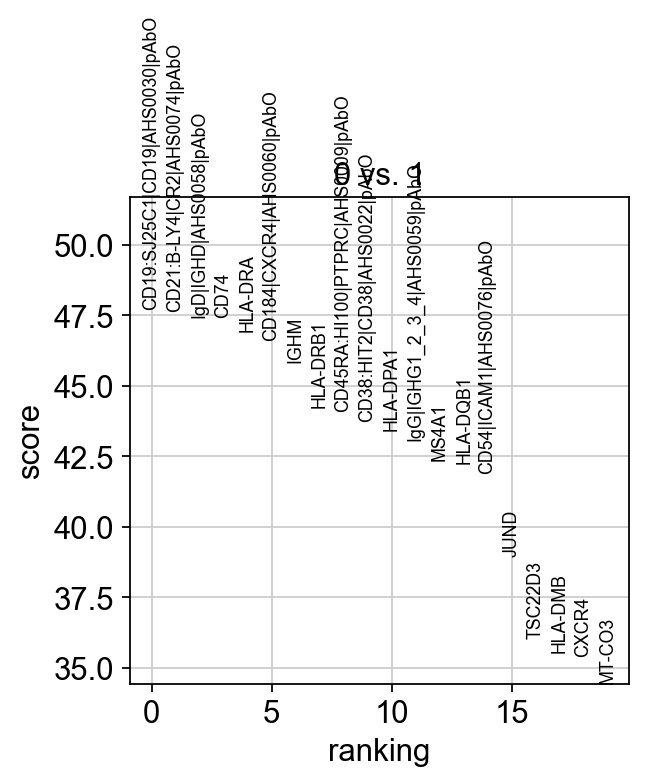

In [40]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use sc.pl.rank_genes_groups_violin.

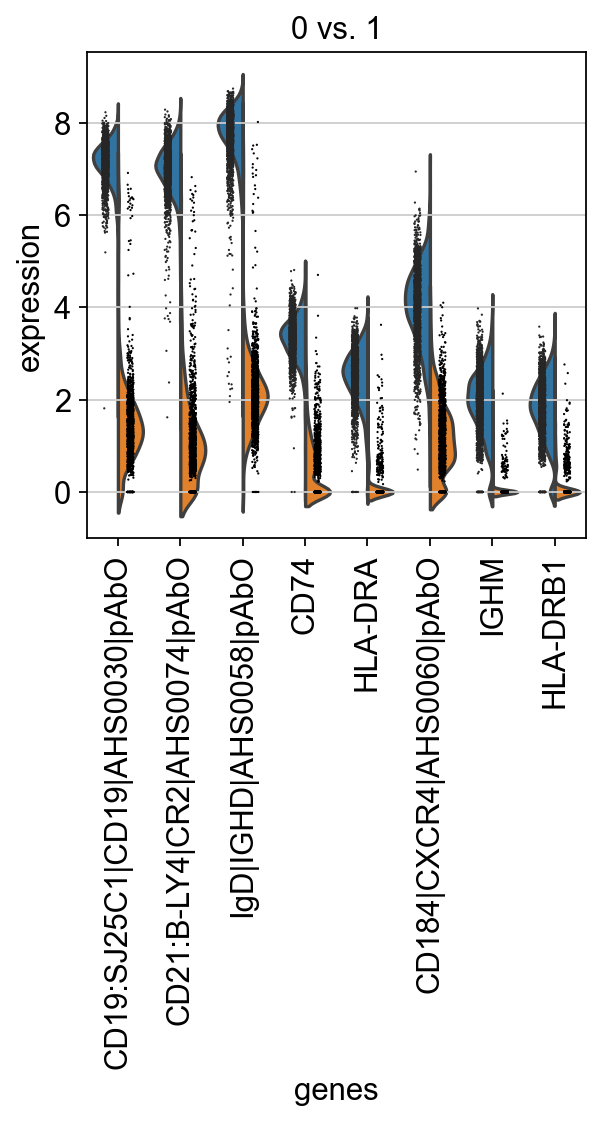

In [41]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [42]:
adata = sc.read(results_file)

In [43]:
# This is throwing a key error

#sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

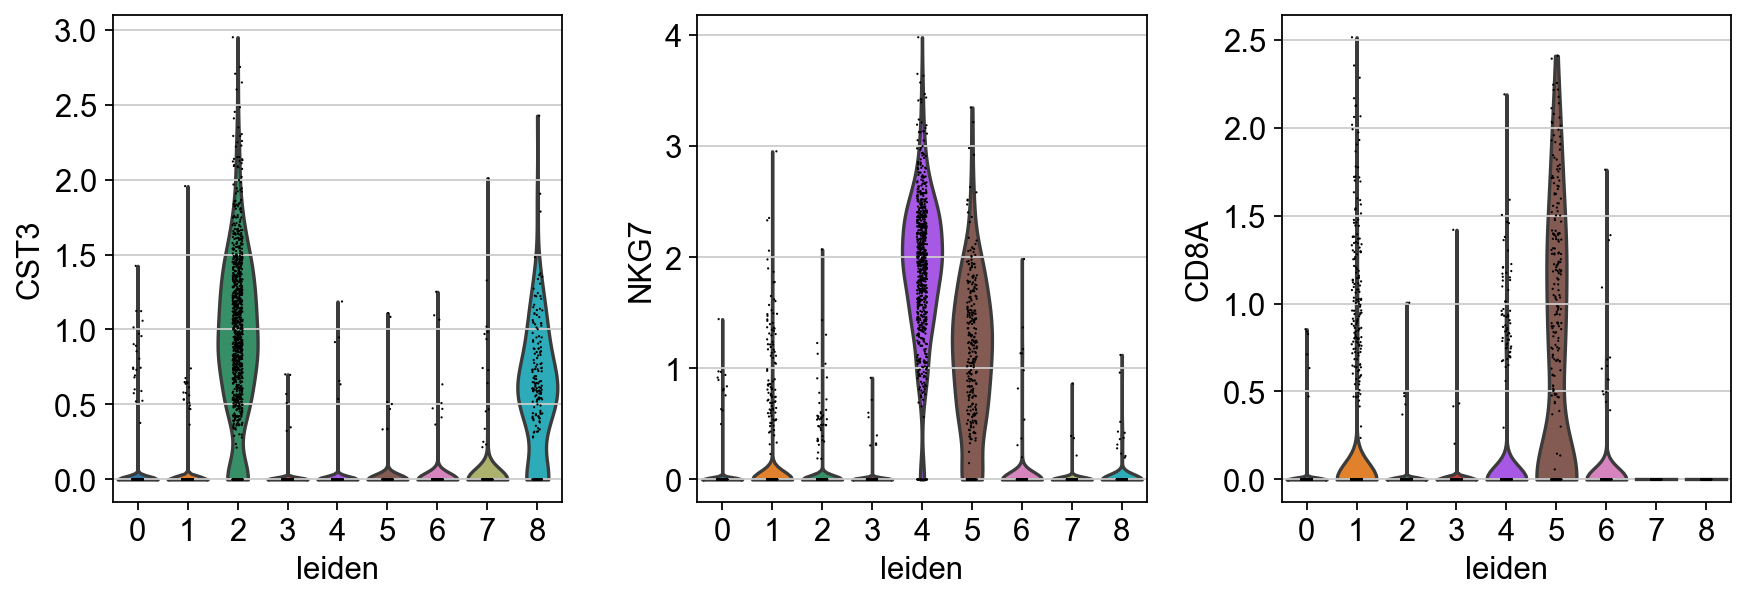

In [44]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'CD8A'], groupby='leiden')

Actually mark the cell types.

In [47]:
# This still needs to be updated for our demo data

new_cluster_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8']
adata.rename_categories('leiden', new_cluster_names)

/Users/miasteinberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1163: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


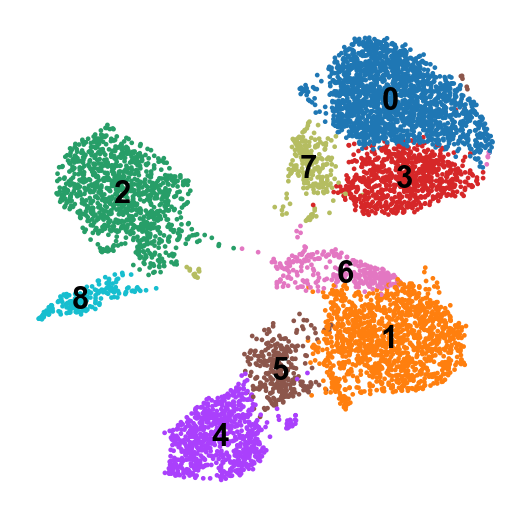

In [48]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

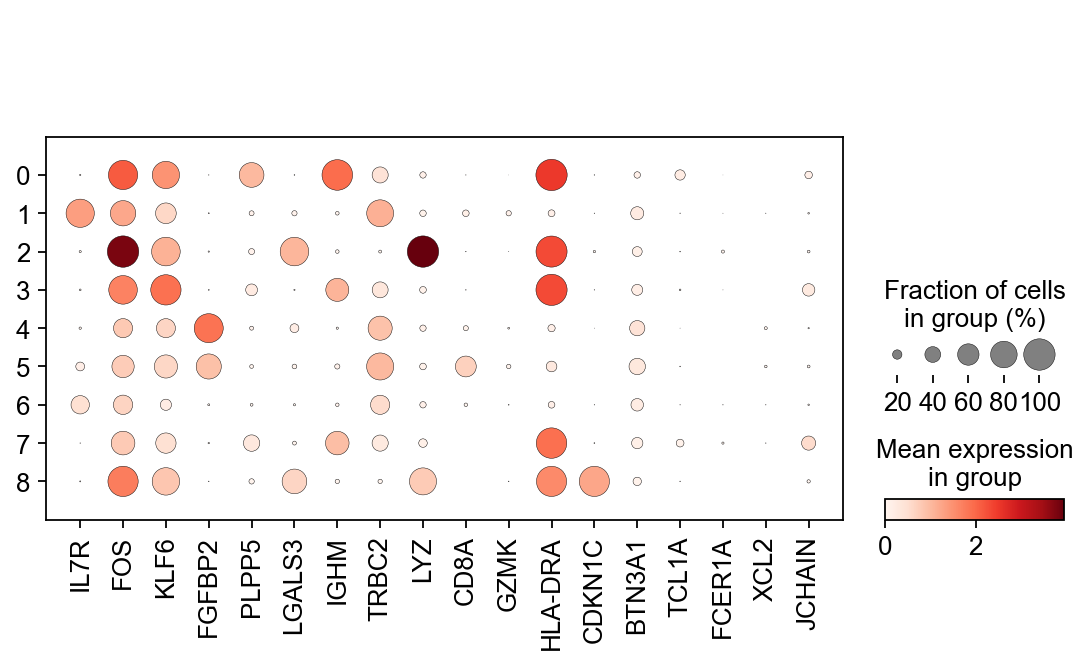

In [49]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

There is also a very compact violin plot.

In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

During the course of this analysis, the AnnData accumlated the following annotations.

In [ ]:
adata

In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

In [ ]:
# If you want to export to “csv”, you have the following options:

# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )